<a href="https://colab.research.google.com/github/maximum4645/ImageClassification/blob/main/exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Data

In [2]:
# Define transformations for normalization and data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Define class labels
classes = train_set.classes
print("Classes:", classes)

# Print dataset sizes
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")

100%|██████████| 170M/170M [00:04<00:00, 39.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train dataset size: 50000
Test dataset size: 10000


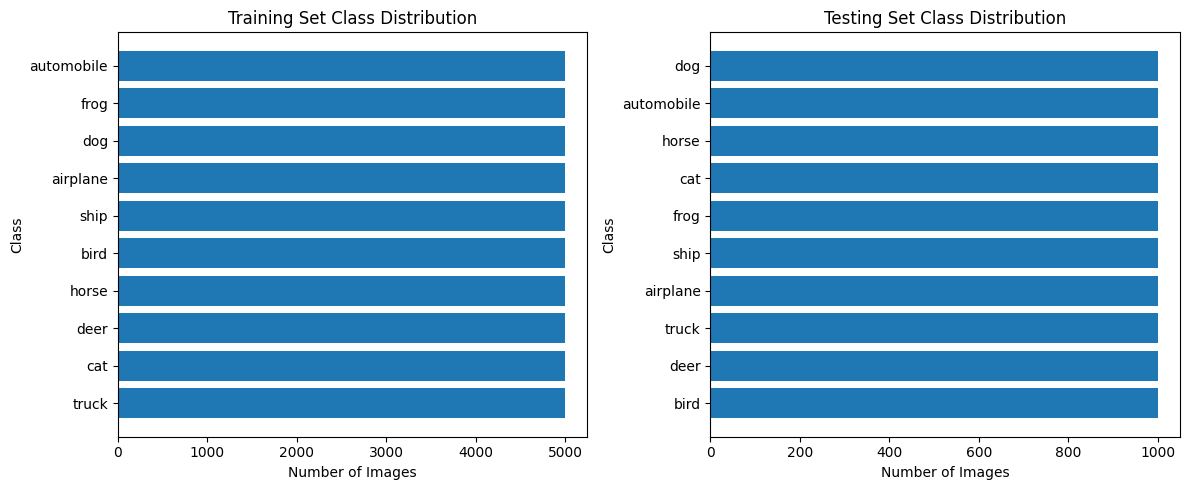

In [3]:
# Calculate class distributions
train_counter = Counter(train_set.targets)
test_counter = Counter(test_set.targets)

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=classes)
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=classes)
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


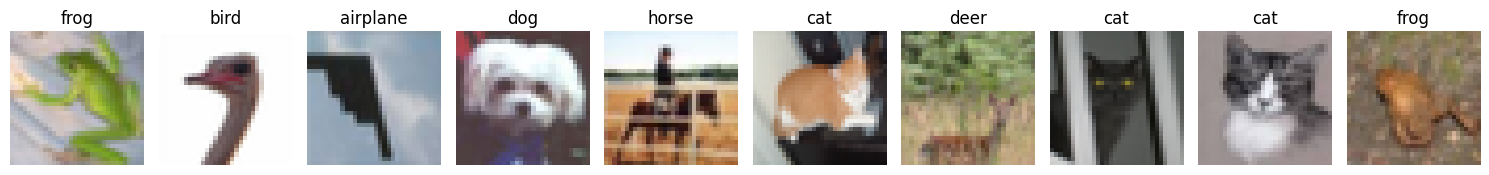

In [4]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10
imshow_with_labels(images[:n], labels[:n], classes)


# Model

In [5]:
# Import necessary libraries
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define ResNet-18
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two residual blocks (layer3 and layer4)
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
# Modify the fully connected (FC) layer for 10 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)
resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
resnet18_model = resnet18_model.to(device)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(pretrained=True)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 10 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, 10)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Define EfficientNet_B0
efficientnet_b0_model = efficientnet_b0(pretrained=True)
for param in efficientnet_b0_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two convolutional blocks
for param in efficientnet_b0_model.features[-2:].parameters():
    param.requires_grad = True
# Modify the classifier for 10 classes
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, 10)
efficientnet_b0_model.classifier[1].requires_grad = True
efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(resnet18_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Before training

ResNet-18 Metrics:
Accuracy: 11.10%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.16      0.17      0.17      1000
  automobile       0.09      0.08      0.09      1000
        bird       0.04      0.01      0.02      1000
         cat       0.12      0.56      0.19      1000
        deer       0.00      0.00      0.00      1000
         dog       0.12      0.04      0.06      1000
        frog       0.09      0.07      0.08      1000
       horse       0.08      0.03      0.04      1000
        ship       0.15      0.05      0.07      1000
       truck       0.09      0.10      0.10      1000

    accuracy                           0.11     10000
   macro avg       0.09      0.11      0.08     10000
weighted avg       0.09      0.11      0.08     10000



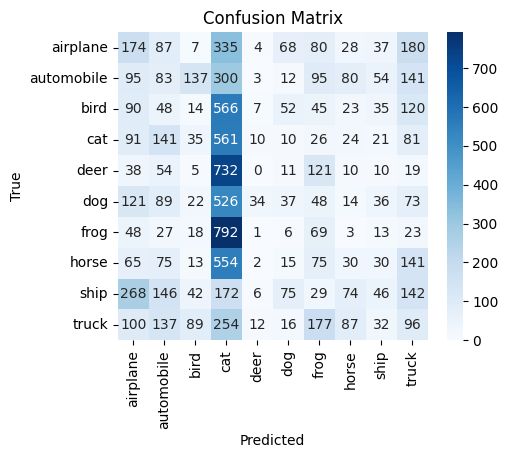


MobileNet_v2 Metrics:
Accuracy: 9.27%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.08      0.28      0.13      1000
  automobile       0.08      0.07      0.08      1000
        bird       0.08      0.03      0.04      1000
         cat       0.07      0.01      0.02      1000
        deer       0.09      0.04      0.06      1000
         dog       0.08      0.06      0.07      1000
        frog       0.16      0.01      0.02      1000
       horse       0.03      0.01      0.02      1000
        ship       0.13      0.39      0.19      1000
       truck       0.05      0.03      0.03      1000

    accuracy                           0.09     10000
   macro avg       0.09      0.09      0.07     10000
weighted avg       0.09      0.09      0.07     10000



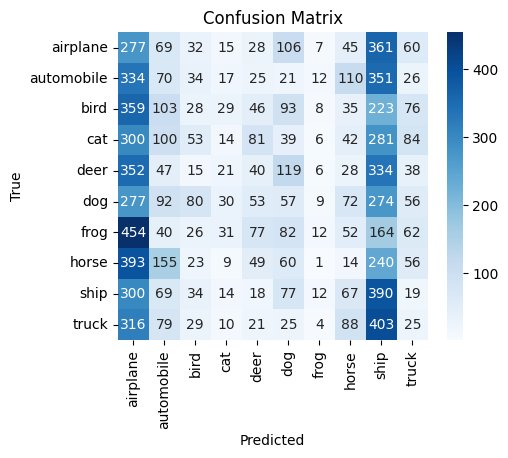


EfficientNet_B0 Metrics:
Accuracy: 11.89%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.13      0.13      0.13      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.09      0.01      0.02      1000
         cat       0.04      0.00      0.00      1000
        deer       0.38      0.01      0.02      1000
         dog       0.17      0.00      0.00      1000
        frog       0.10      0.82      0.18      1000
       horse       0.00      0.00      0.00      1000
        ship       0.03      0.00      0.00      1000
       truck       0.31      0.21      0.25      1000

    accuracy                           0.12     10000
   macro avg       0.12      0.12      0.06     10000
weighted avg       0.12      0.12      0.06     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


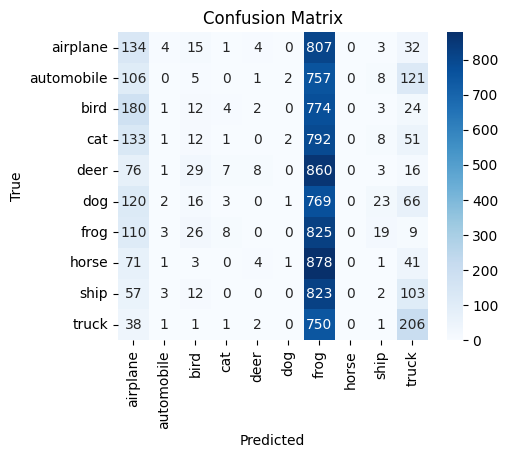

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


# Training

In [7]:
import torch.optim as optim
from torch.utils.data import random_split

# Define the training function
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase (if val_loader is provided)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# Split the training data
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# Define common settings
criterion = torch.nn.CrossEntropyLoss()

# Train ResNet-18
print("Training ResNet-18...")
resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
resnet18_train_losses, resnet18_val_losses = train_model(
    resnet18_model, train_loader, val_loader, criterion, resnet18_optimizer, device
)

# Train MobileNet_v2
print("\nTraining MobileNet_v2...")
mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
    mobilenet_v2_model, train_loader, val_loader, criterion, mobilenet_v2_optimizer, device
)

# Train EfficientNet_B0
print("\nTraining EfficientNet_B0...")
efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.001, momentum=0.9)
efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
    efficientnet_b0_model, train_loader, val_loader, criterion, efficientnet_b0_optimizer, device
)


Training ResNet-18...
Epoch 1/20, Train Loss: 1.1992, Val Loss: 0.8918
Epoch 2/20, Train Loss: 0.7809, Val Loss: 0.8002
Epoch 3/20, Train Loss: 0.6132, Val Loss: 0.7803
Epoch 4/20, Train Loss: 0.4834, Val Loss: 0.7919
Epoch 5/20, Train Loss: 0.3739, Val Loss: 0.8380
Epoch 6/20, Train Loss: 0.2898, Val Loss: 0.8967
Epoch 7/20, Train Loss: 0.2174, Val Loss: 0.9556
Early stopping at epoch 8

Training MobileNet_v2...
Epoch 1/20, Train Loss: 1.1756, Val Loss: 0.8847
Epoch 2/20, Train Loss: 0.8238, Val Loss: 0.7557
Epoch 3/20, Train Loss: 0.6936, Val Loss: 0.7216
Epoch 4/20, Train Loss: 0.6221, Val Loss: 0.6891
Epoch 5/20, Train Loss: 0.5414, Val Loss: 0.6707
Epoch 6/20, Train Loss: 0.4768, Val Loss: 0.6550
Epoch 7/20, Train Loss: 0.4230, Val Loss: 0.6833
Epoch 8/20, Train Loss: 0.3823, Val Loss: 0.6843
Epoch 9/20, Train Loss: 0.3379, Val Loss: 0.7036
Epoch 10/20, Train Loss: 0.2998, Val Loss: 0.7233
Early stopping at epoch 11

Training EfficientNet_B0...
Epoch 1/20, Train Loss: 1.9256, Val 

# After training

ResNet-18 Metrics:
Accuracy: 74.83%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.79      0.79      0.79      1000
  automobile       0.83      0.82      0.83      1000
        bird       0.75      0.63      0.68      1000
         cat       0.58      0.58      0.58      1000
        deer       0.69      0.73      0.71      1000
         dog       0.64      0.66      0.65      1000
        frog       0.76      0.83      0.79      1000
       horse       0.81      0.77      0.79      1000
        ship       0.85      0.85      0.85      1000
       truck       0.78      0.84      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



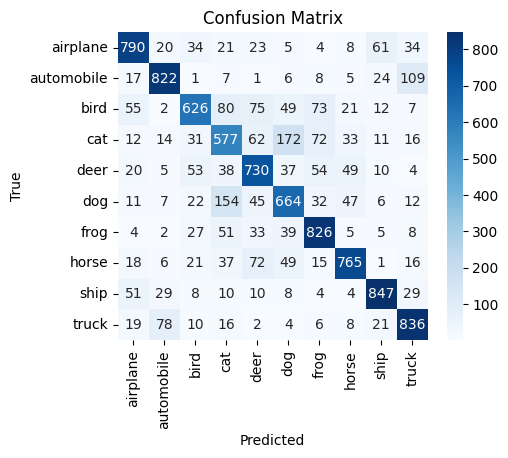


MobileNet_v2 Metrics:
Accuracy: 76.65%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.80      0.80      1000
  automobile       0.86      0.87      0.86      1000
        bird       0.72      0.68      0.70      1000
         cat       0.58      0.62      0.60      1000
        deer       0.77      0.67      0.72      1000
         dog       0.66      0.67      0.66      1000
        frog       0.76      0.86      0.81      1000
       horse       0.82      0.78      0.80      1000
        ship       0.86      0.87      0.86      1000
       truck       0.85      0.84      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



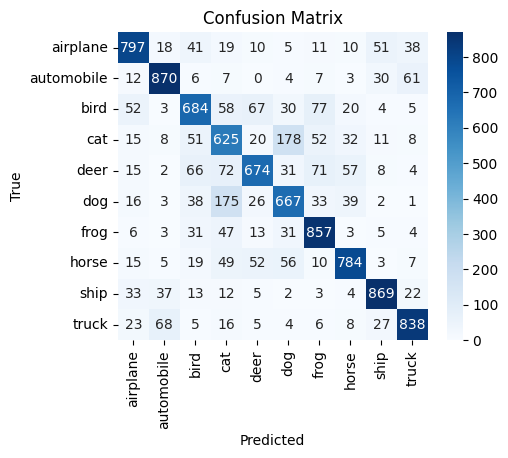


EfficientNet_B0 Metrics:
Accuracy: 51.69%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.53      0.54      0.54      1000
  automobile       0.60      0.56      0.58      1000
        bird       0.43      0.41      0.42      1000
         cat       0.39      0.45      0.41      1000
        deer       0.50      0.45      0.47      1000
         dog       0.50      0.41      0.45      1000
        frog       0.56      0.59      0.58      1000
       horse       0.58      0.58      0.58      1000
        ship       0.55      0.58      0.57      1000
       truck       0.54      0.60      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



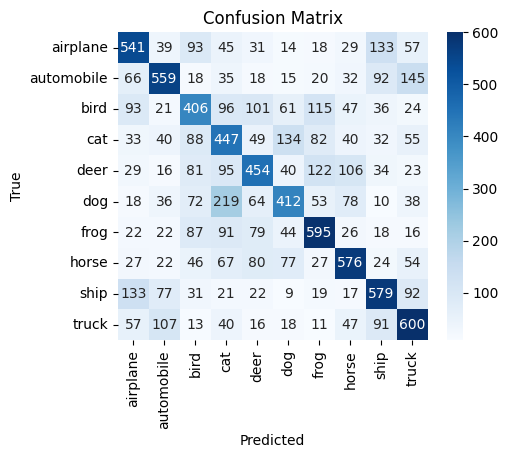

In [8]:
# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


In [9]:
# Store results for comparison
results = {
    "ResNet-18": {
        "Before Training": {"Accuracy": resnet18_accuracy_before},
        "After Training": {"Accuracy": resnet18_accuracy_after},
    },
    "MobileNet_v2": {
        "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
        "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
    },
    "EfficientNet_B0": {
        "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
        "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
    },
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



ResNet-18 Results:
  Before Training Accuracy: 11.10%
  After Training Accuracy: 74.83%

MobileNet_v2 Results:
  Before Training Accuracy: 9.27%
  After Training Accuracy: 76.65%

EfficientNet_B0 Results:
  Before Training Accuracy: 11.89%
  After Training Accuracy: 51.69%


ResNet-18 Misclassifications:


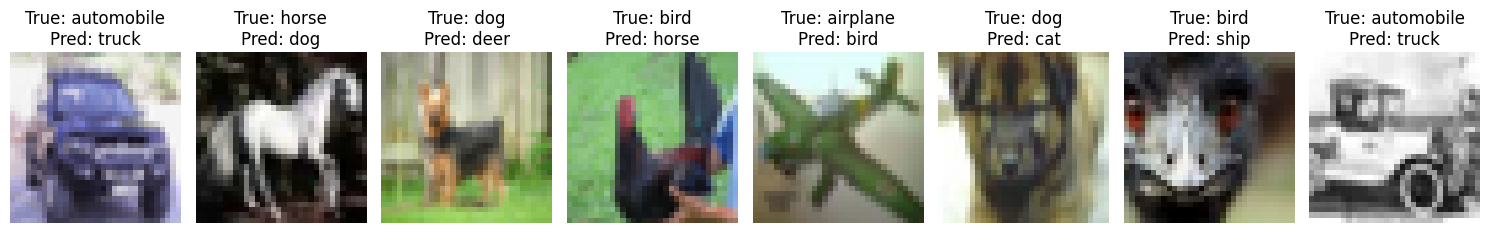

In [10]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(resnet18_model, test_loader, device, classes, num_images=8)


In [11]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a symbolic link for easier access
!ln -s "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Experimentation" /content/Experimentation
print("Symbolic link created: /content/Experimentation")

# Define the path to the Results folder
folder_path = '/content/Experimentation/Results'

# Create the Results folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Define the path for the JSON file for Version 3
json_file_path = os.path.join(folder_path, "model_results_v3.json")

# Save the results as Version 3
try:
    with open(json_file_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Version 3 Results saved to: {json_file_path}")
except NameError:
    print("Error: The 'results' dictionary is not defined. Ensure you have results from your experiments.")


Mounted at /content/drive
Symbolic link created: /content/Experimentation
Folder created (or already exists) at: /content/Experimentation/Results
Version 3 Results saved to: /content/Experimentation/Results/model_results_v3.json
